In [19]:
from pathlib import Path

# Dataset Path
DATASET_PATH = Path("/kaggle/input/plantvillage-tomato-leaf-dataset/plantvillage/plantvillage")

# List all classes
classes = sorted([d.name for d in DATASET_PATH.iterdir() if d.is_dir()])

print("  Dataset Path:", DATASET_PATH)
print("  Total Classes:", len(classes))
print("  Class List:")
for c in classes:
    print("-", c)


  Dataset Path: /kaggle/input/plantvillage-tomato-leaf-dataset/plantvillage/plantvillage
  Total Classes: 10
  Class List:
- Tomato___Bacterial_spot
- Tomato___Early_blight
- Tomato___Late_blight
- Tomato___Leaf_Mold
- Tomato___Septoria_leaf_spot
- Tomato___Spider_mites Two-spotted_spider_mite
- Tomato___Target_Spot
- Tomato___Tomato_Yellow_Leaf_Curl_Virus
- Tomato___Tomato_mosaic_virus
- Tomato___healthy


In [ ]:
import os
import logging


os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'    


os.environ['PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION'] = 'python'

import tensorflow as tf


tf.get_logger().setLevel('ERROR')


logging.getLogger("tensorflow").setLevel(logging.ERROR)


In [21]:
#    70/15/15   split
from pathlib import Path
import pandas as pd
from sklearn.model_selection import train_test_split
import random

#  DATASET_PATH 
DATASET_PATH = Path("/kaggle/input/plantvillage-tomato-leaf-dataset/plantvillage/plantvillage")

# Allowed image extensions
exts = (".jpg", ".jpeg", ".png", ".bmp")

# Collect image file paths and labels
rows = []
for cls_dir in sorted([p for p in DATASET_PATH.iterdir() if p.is_dir()]):
    cls_name = cls_dir.name
    for img_path in cls_dir.rglob("*"):
        if img_path.suffix.lower() in exts and img_path.is_file():
            rows.append({"filepath": str(img_path), "label": cls_name})

df = pd.DataFrame(rows)
df = df.sample(frac=1, random_state=42).reset_index(drop=True)   

# Quick checks
print("Total images found:", len(df))
print("Classes found:", df['label'].nunique())
print(df['label'].value_counts())

# Train  (70% / 30%)
train_df, temp_df = train_test_split(
    df, test_size=0.30, stratify=df['label'], random_state=42
)

# Temp -> Validation & Test each 50% of temp => 15% each of total
val_df, test_df = train_test_split(
    temp_df, test_size=0.5, stratify=temp_df['label'], random_state=42
)

# Print split sizes and per-class counts
print("\nSplit sizes:")
print(" Train:", len(train_df))
print(" Val:  ", len(val_df))
print(" Test: ", len(test_df))

print("\nPer-class counts (train):")
print(train_df['label'].value_counts())
print("\nPer-class counts (val):")
print(val_df['label'].value_counts())
print("\nPer-class counts (test):")
print(test_df['label'].value_counts())

# Show a small sample of train rows
print("\nSample of train rows:")
display(train_df.head(6))


Total images found: 14529
Classes found: 10
label
Tomato___Tomato_Yellow_Leaf_Curl_Virus           4286
Tomato___Bacterial_spot                          1702
Tomato___Late_blight                             1527
Tomato___Septoria_leaf_spot                      1417
Tomato___Spider_mites Two-spotted_spider_mite    1341
Tomato___healthy                                 1273
Tomato___Target_Spot                             1123
Tomato___Early_blight                             800
Tomato___Leaf_Mold                                761
Tomato___Tomato_mosaic_virus                      299
Name: count, dtype: int64

Split sizes:
 Train: 10170
 Val:   2179
 Test:  2180

Per-class counts (train):
label
Tomato___Tomato_Yellow_Leaf_Curl_Virus           3000
Tomato___Bacterial_spot                          1191
Tomato___Late_blight                             1069
Tomato___Septoria_leaf_spot                       992
Tomato___Spider_mites Two-spotted_spider_mite     939
Tomato___healthy           

filepath  \
3715   /kaggle/input/plantvillage-tomato-leaf-dataset...   
3663   /kaggle/input/plantvillage-tomato-leaf-dataset...   
7990   /kaggle/input/plantvillage-tomato-leaf-dataset...   
7160   /kaggle/input/plantvillage-tomato-leaf-dataset...   
13925  /kaggle/input/plantvillage-tomato-leaf-dataset...   
2978   /kaggle/input/plantvillage-tomato-leaf-dataset...   

                                               label  
3715                         Tomato___Bacterial_spot  
3663          Tomato___Tomato_Yellow_Leaf_Curl_Virus  
7990                            Tomato___Late_blight  
7160                         Tomato___Bacterial_spot  
13925  Tomato___Spider_mites Two-spotted_spider_mite  
2978                            Tomato___Target_Spot

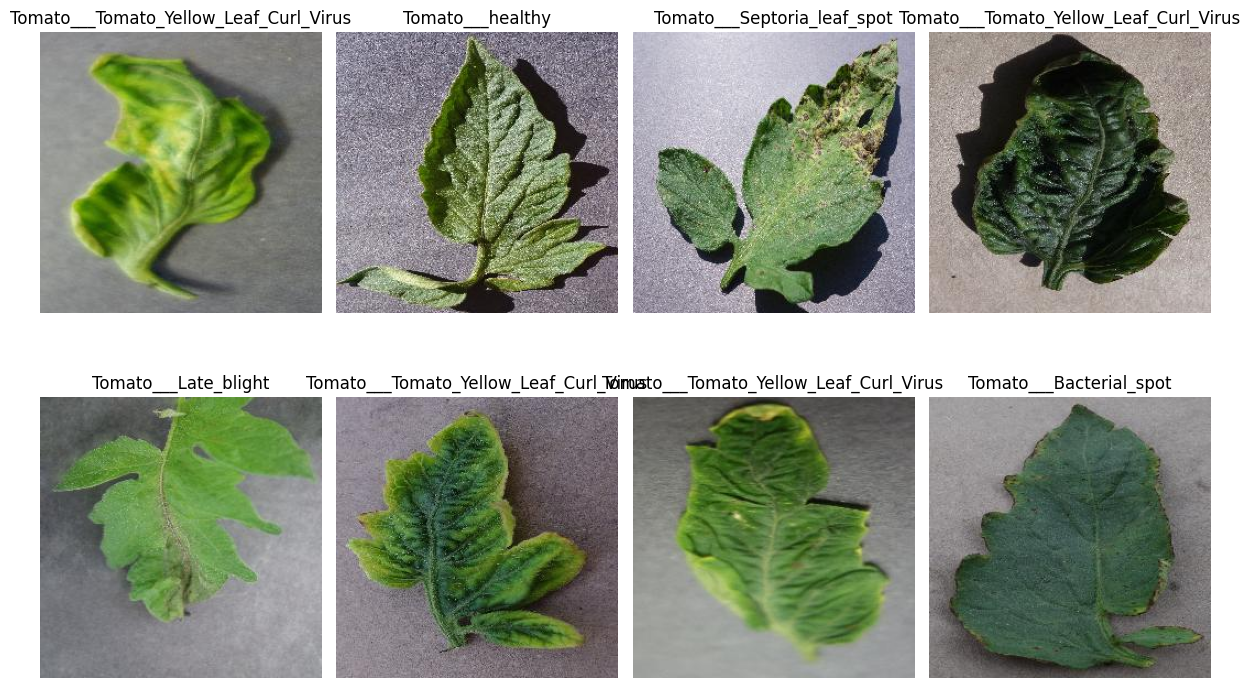

In [22]:
#  Show sample train images
import matplotlib.pyplot as plt
import random
from PIL import Image

 
sample_paths = train_df.sample(8, random_state=42)

plt.figure(figsize=(12, 8))

for i, row in enumerate(sample_paths.itertuples(), 1):
    img = Image.open(row.filepath)
    plt.subplot(2, 4, i)
    plt.imshow(img)
    plt.title(row.label)
    plt.axis("off")

plt.tight_layout()
plt.show()


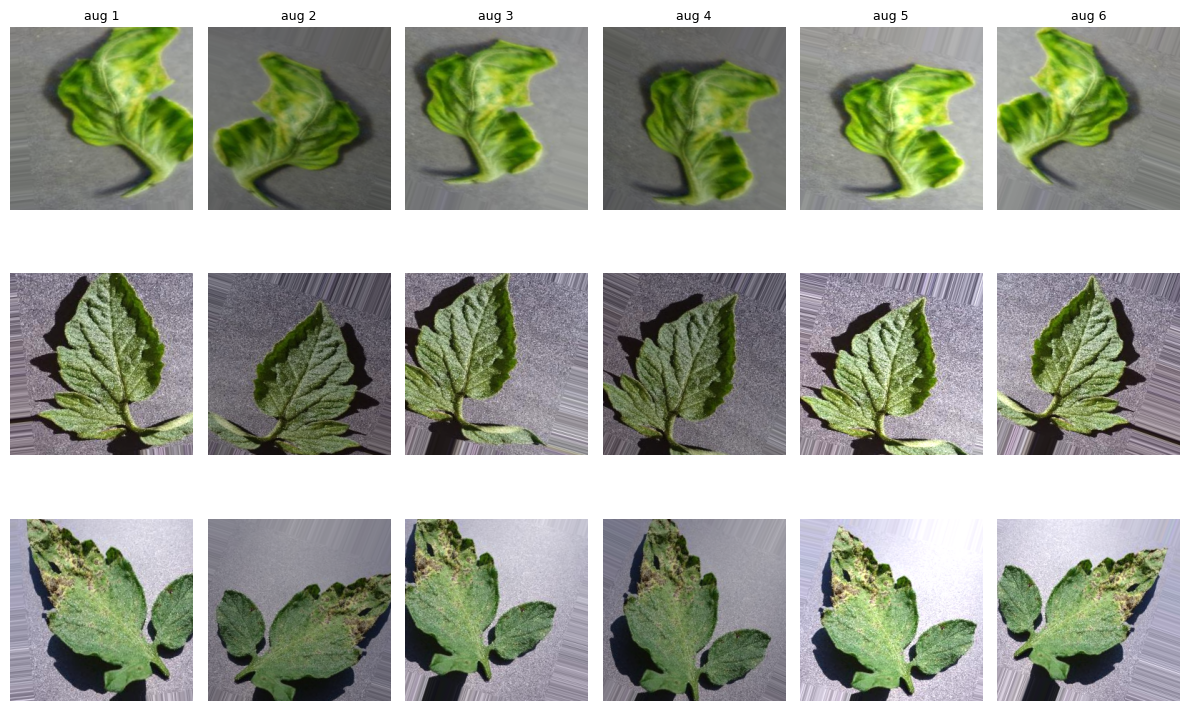

In [23]:
# Data augmentation 
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img

# Augmentation config  
aug = ImageDataGenerator(
    rotation_range=25,
    width_shift_range=0.12,
    height_shift_range=0.12,
    shear_range=0.12,
    zoom_range=0.12,
    horizontal_flip=True,
    brightness_range=(0.7, 1.3),
    fill_mode="nearest"
)

# Choose 3 random images from train set  
np.random.seed(42)
sample_rows = train_df.sample(3, random_state=42).reset_index(drop=True)

# For each chosen image, generate 6 augmented variants
n_variants = 6
plt.figure(figsize=(12, 8))

for r_idx, row in sample_rows.iterrows():
    img = load_img(row.filepath)              
    x = img_to_array(img)                     
    x = x.reshape((1,) + x.shape)             

    it = aug.flow(x, batch_size=1, shuffle=False, seed=42)
    for v in range(n_variants):
        batch = next(it)
        aug_img = batch[0].astype('uint8')
        ax = plt.subplot(len(sample_rows), n_variants, r_idx * n_variants + v + 1)
        plt.imshow(aug_img)
        if v == 0:
            plt.ylabel(row.label, fontsize=10)
        plt.axis("off")
        if r_idx == 0:
            ax.set_title(f"aug {v+1}", fontsize=9)

plt.tight_layout()
plt.show()


Found 10170 validated image filenames belonging to 10 classes.
Found 2179 validated image filenames belonging to 10 classes.
Found 2180 validated image filenames belonging to 10 classes.
Train samples: 10170 | steps_per_epoch: 317
Val samples:   2179 | batches: 69
Test samples:  2180 | batches: 69

Class indices:
{'Tomato___Bacterial_spot': 0, 'Tomato___Early_blight': 1, 'Tomato___Late_blight': 2, 'Tomato___Leaf_Mold': 3, 'Tomato___Septoria_leaf_spot': 4, 'Tomato___Spider_mites Two-spotted_spider_mite': 5, 'Tomato___Target_Spot': 6, 'Tomato___Tomato_Yellow_Leaf_Curl_Virus': 7, 'Tomato___Tomato_mosaic_virus': 8, 'Tomato___healthy': 9}

One batch shapes: (32, 224, 224, 3) (32, 10)


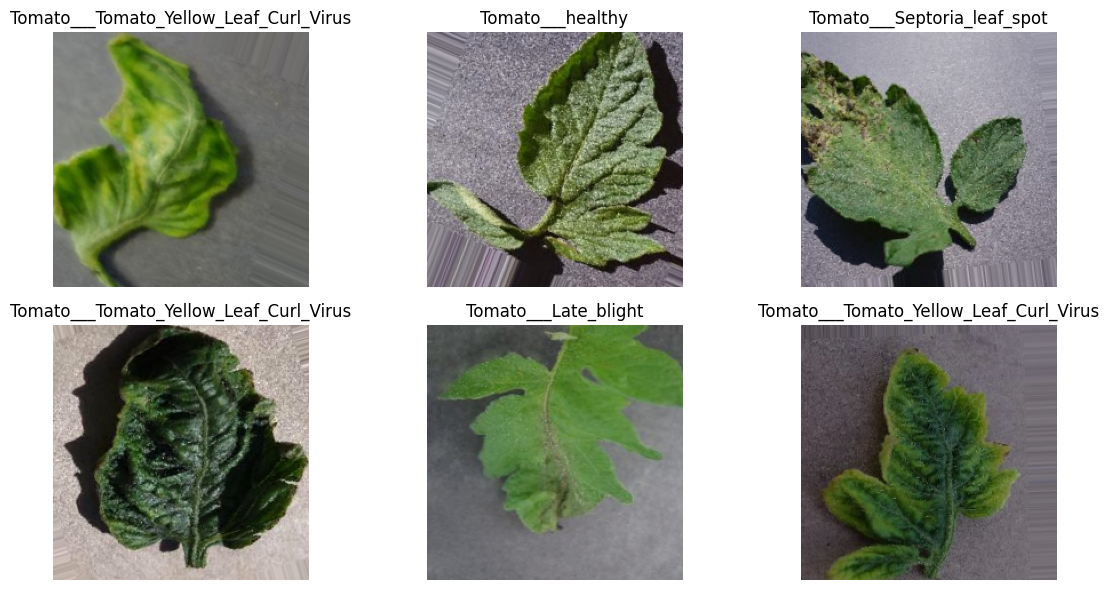

In [24]:
#   ImageDataGenerator -> train / val / test generators 
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_SIZE = (224, 224)
BATCH_SIZE = 32
SEED = 42

# train augmentation  
train_aug = ImageDataGenerator(
    rescale=1./255,
    rotation_range=25,
    width_shift_range=0.12,
    height_shift_range=0.12,
    shear_range=0.12,
    zoom_range=0.12,
    horizontal_flip=True,
    brightness_range=(0.7, 1.3),
    fill_mode="nearest"
)

# validation / test: only rescale
val_test_aug = ImageDataGenerator(rescale=1./255)

 
train_gen = train_aug.flow_from_dataframe(
    dataframe=train_df,
    x_col="filepath",
    y_col="label",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=True,
    seed=SEED
)

val_gen = val_test_aug.flow_from_dataframe(
    dataframe=val_df,
    x_col="filepath",
    y_col="label",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False,
    seed=SEED
)

test_gen = val_test_aug.flow_from_dataframe(
    dataframe=test_df,
    x_col="filepath",
    y_col="label",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False,    
    seed=SEED
)

# Quick prints for sanity
print("Train samples:", train_gen.n, "| steps_per_epoch:", train_gen.samples // BATCH_SIZE)
print("Val samples:  ", val_gen.n,   "| batches:", np.ceil(val_gen.samples / BATCH_SIZE).astype(int))
print("Test samples: ", test_gen.n,  "| batches:", np.ceil(test_gen.samples / BATCH_SIZE).astype(int))
print("\nClass indices:")
print(train_gen.class_indices)

 
batch_x, batch_y = next(train_gen)
print("\nOne batch shapes:", batch_x.shape, batch_y.shape)

# Visualize first 6 images from that batch with their labels
plt.figure(figsize=(12, 6))
for i in range(6):
    ax = plt.subplot(2, 3, i+1)
    plt.imshow(batch_x[i])
    lbl = list(train_gen.class_indices.keys())[np.argmax(batch_y[i])]
    plt.title(lbl)
    plt.axis("off")
plt.tight_layout()
plt.show()


In [25]:
#  Build  CNN model  

import tensorflow as tf
from tensorflow.keras import layers, models

IMG_SIZE = (224, 224, 3)

 
NUM_CLASSES = len(train_gen.class_indices)

model = models.Sequential([
    # Block 1
    layers.Conv2D(32, (3,3), activation='relu', padding='same', input_shape=IMG_SIZE),
    layers.MaxPooling2D((2,2)),

    # Block 2
    layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    layers.MaxPooling2D((2,2)),

    # Block 3
    layers.Conv2D(128, (3,3), activation='relu', padding='same'),
    layers.MaxPooling2D((2,2)),

    # Classifier
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(NUM_CLASSES, activation='softmax')
])

model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │    12,845,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,939,722 (49.36 MB)

 Trainable params: 12,939,722 (49.36 MB)

 Non-trainable params: 0 (0.00 B)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
318/318 ━━━━━━━━━━━━━━━━━━━━ 0s 454ms/step - accuracy: 0.4104 - loss: 1.7882
Epoch 1: val_loss improved from inf to 1.10430, saving model to best_model.h5


318/318 ━━━━━━━━━━━━━━━━━━━━ 163s 502ms/step - accuracy: 0.4108 - loss: 1.7870 - val_accuracy: 0.6287 - val_loss: 1.1043
Epoch 2/50
318/318 ━━━━━━━━━━━━━━━━━━━━ 0s 413ms/step - accuracy: 0.7001 - loss: 0.8851
Epoch 2: val_loss improved from 1.10430 to 0.70820, saving model to best_model.h5


318/318 ━━━━━━━━━━━━━━━━━━━━ 136s 427ms/step - accuracy: 0.7001 - loss: 0.8850 - val_accuracy: 0.7513 - val_loss: 0.7082
Epoch 3/50
318/318 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step - accuracy: 0.7600 - loss: 0.6869
Epoch 3: val_loss improved from 0.70820 to 0.56623, saving model to best_model.h5


318/318 ━━━━━━━━━━━━━━━━━━━━ 137s 429ms/step - accuracy: 0.7600 - loss: 0.6868 - val_accuracy: 0.8054 - val_loss: 0.5662
Epoch 4/50
318/318 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step - accuracy: 0.7969 - loss: 0.5816
Epoch 4: val_loss did not improve from 0.56623
318/318 ━━━━━━━━━━━━━━━━━━━━ 136s 428ms/step - accuracy: 0.7970 - loss: 0.5815 - val_accuracy: 0.7903 - val_loss: 0.6809
Epoch 5/50
318/318 ━━━━━━━━━━━━━━━━━━━━ 0s 420ms/step - accuracy: 0.8200 - loss: 0.5349
Epoch 5: val_loss improved from 0.56623 to 0.46681, saving model to best_model.h5


318/318 ━━━━━━━━━━━━━━━━━━━━ 138s 435ms/step - accuracy: 0.8200 - loss: 0.5348 - val_accuracy: 0.8577 - val_loss: 0.4668
Epoch 6/50
318/318 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step - accuracy: 0.8409 - loss: 0.4626
Epoch 6: val_loss did not improve from 0.46681
318/318 ━━━━━━━━━━━━━━━━━━━━ 134s 421ms/step - accuracy: 0.8409 - loss: 0.4625 - val_accuracy: 0.8472 - val_loss: 0.5152
Epoch 7/50
318/318 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step - accuracy: 0.8570 - loss: 0.4078
Epoch 7: val_loss did not improve from 0.46681
318/318 ━━━━━━━━━━━━━━━━━━━━ 136s 427ms/step - accuracy: 0.8570 - loss: 0.4077 - val_accuracy: 0.7779 - val_loss: 0.8345
Epoch 8/50
318/318 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step - accuracy: 0.8625 - loss: 0.3842
Epoch 8: val_loss did not improve from 0.46681
318/318 ━━━━━━━━━━━━━━━━━━━━ 134s 420ms/step - accuracy: 0.8625 - loss: 0.3842 - val_accuracy: 0.8486 - val_loss: 0.5504
Epoch 9/50
318/318 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step - accuracy: 0.8753 - loss: 0.3557
Epoch 9: val_loss did n

318/318 ━━━━━━━━━━━━━━━━━━━━ 134s 422ms/step - accuracy: 0.8787 - loss: 0.3536 - val_accuracy: 0.8963 - val_loss: 0.3771
Epoch 11/50
318/318 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step - accuracy: 0.8958 - loss: 0.3012
Epoch 11: val_loss improved from 0.37708 to 0.36640, saving model to best_model.h5


318/318 ━━━━━━━━━━━━━━━━━━━━ 135s 423ms/step - accuracy: 0.8957 - loss: 0.3013 - val_accuracy: 0.8885 - val_loss: 0.3664
Epoch 12/50
318/318 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step - accuracy: 0.9016 - loss: 0.2887
Epoch 12: val_loss did not improve from 0.36640
318/318 ━━━━━━━━━━━━━━━━━━━━ 134s 422ms/step - accuracy: 0.9016 - loss: 0.2888 - val_accuracy: 0.8651 - val_loss: 0.4925
Epoch 13/50
318/318 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step - accuracy: 0.8965 - loss: 0.2909
Epoch 13: val_loss improved from 0.36640 to 0.35396, saving model to best_model.h5


318/318 ━━━━━━━━━━━━━━━━━━━━ 137s 429ms/step - accuracy: 0.8965 - loss: 0.2909 - val_accuracy: 0.8940 - val_loss: 0.3540
Epoch 14/50
318/318 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step - accuracy: 0.9042 - loss: 0.2586
Epoch 14: val_loss improved from 0.35396 to 0.26051, saving model to best_model.h5


318/318 ━━━━━━━━━━━━━━━━━━━━ 138s 432ms/step - accuracy: 0.9042 - loss: 0.2587 - val_accuracy: 0.9151 - val_loss: 0.2605
Epoch 15/50
318/318 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step - accuracy: 0.9072 - loss: 0.2550
Epoch 15: val_loss did not improve from 0.26051
318/318 ━━━━━━━━━━━━━━━━━━━━ 134s 421ms/step - accuracy: 0.9072 - loss: 0.2550 - val_accuracy: 0.8944 - val_loss: 0.3498
Epoch 16/50
318/318 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step - accuracy: 0.9058 - loss: 0.2511
Epoch 16: val_loss did not improve from 0.26051
318/318 ━━━━━━━━━━━━━━━━━━━━ 136s 426ms/step - accuracy: 0.9058 - loss: 0.2510 - val_accuracy: 0.9275 - val_loss: 0.2635
Epoch 17/50
318/318 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step - accuracy: 0.9209 - loss: 0.2295
Epoch 17: val_loss did not improve from 0.26051
318/318 ━━━━━━━━━━━━━━━━━━━━ 132s 415ms/step - accuracy: 0.9208 - loss: 0.2295 - val_accuracy: 0.8821 - val_loss: 0.3514
Epoch 18/50
318/318 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step - accuracy: 0.9156 - loss: 0.2381
Epoch 18: val_lo

318/318 ━━━━━━━━━━━━━━━━━━━━ 133s 418ms/step - accuracy: 0.9157 - loss: 0.2381 - val_accuracy: 0.9358 - val_loss: 0.1882
Epoch 19/50
318/318 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step - accuracy: 0.9151 - loss: 0.2368
Epoch 19: val_loss did not improve from 0.18825
318/318 ━━━━━━━━━━━━━━━━━━━━ 135s 424ms/step - accuracy: 0.9151 - loss: 0.2368 - val_accuracy: 0.9371 - val_loss: 0.2057
Epoch 20/50
318/318 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step - accuracy: 0.9215 - loss: 0.2246
Epoch 20: val_loss did not improve from 0.18825
318/318 ━━━━━━━━━━━━━━━━━━━━ 133s 419ms/step - accuracy: 0.9215 - loss: 0.2246 - val_accuracy: 0.9335 - val_loss: 0.2101
Epoch 21/50
318/318 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step - accuracy: 0.9281 - loss: 0.2093
Epoch 21: val_loss did not improve from 0.18825
318/318 ━━━━━━━━━━━━━━━━━━━━ 133s 417ms/step - accuracy: 0.9281 - loss: 0.2093 - val_accuracy: 0.9321 - val_loss: 0.2170
Epoch 22/50
318/318 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step - accuracy: 0.9289 - loss: 0.2147
Epoch 22: val_lo

318/318 ━━━━━━━━━━━━━━━━━━━━ 135s 423ms/step - accuracy: 0.9289 - loss: 0.2146 - val_accuracy: 0.9486 - val_loss: 0.1666
Epoch 23/50
318/318 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step - accuracy: 0.9409 - loss: 0.1646
Epoch 23: val_loss did not improve from 0.16656
318/318 ━━━━━━━━━━━━━━━━━━━━ 133s 418ms/step - accuracy: 0.9409 - loss: 0.1647 - val_accuracy: 0.9243 - val_loss: 0.2581
Epoch 24/50
318/318 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step - accuracy: 0.9309 - loss: 0.2081
Epoch 24: val_loss improved from 0.16656 to 0.15149, saving model to best_model.h5


318/318 ━━━━━━━━━━━━━━━━━━━━ 133s 419ms/step - accuracy: 0.9309 - loss: 0.2081 - val_accuracy: 0.9514 - val_loss: 0.1515
Epoch 25/50
318/318 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step - accuracy: 0.9316 - loss: 0.2001
Epoch 25: val_loss did not improve from 0.15149
318/318 ━━━━━━━━━━━━━━━━━━━━ 134s 420ms/step - accuracy: 0.9317 - loss: 0.2001 - val_accuracy: 0.9468 - val_loss: 0.1568
Epoch 26/50
318/318 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step - accuracy: 0.9304 - loss: 0.1992
Epoch 26: val_loss did not improve from 0.15149
318/318 ━━━━━━━━━━━━━━━━━━━━ 133s 419ms/step - accuracy: 0.9304 - loss: 0.1991 - val_accuracy: 0.7972 - val_loss: 1.0624
Epoch 27/50
318/318 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step - accuracy: 0.9360 - loss: 0.1903
Epoch 27: val_loss did not improve from 0.15149
318/318 ━━━━━━━━━━━━━━━━━━━━ 133s 419ms/step - accuracy: 0.9360 - loss: 0.1903 - val_accuracy: 0.9275 - val_loss: 0.2497
Epoch 28/50
318/318 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step - accuracy: 0.9423 - loss: 0.1663
Epoch 28: val_lo

318/318 ━━━━━━━━━━━━━━━━━━━━ 135s 424ms/step - accuracy: 0.9423 - loss: 0.1663 - val_accuracy: 0.9504 - val_loss: 0.1426
Epoch 29/50
318/318 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step - accuracy: 0.9351 - loss: 0.1955
Epoch 29: val_loss did not improve from 0.14256
318/318 ━━━━━━━━━━━━━━━━━━━━ 134s 422ms/step - accuracy: 0.9351 - loss: 0.1956 - val_accuracy: 0.9472 - val_loss: 0.1492
Epoch 30/50
318/318 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step - accuracy: 0.9487 - loss: 0.1416
Epoch 30: val_loss did not improve from 0.14256
318/318 ━━━━━━━━━━━━━━━━━━━━ 134s 422ms/step - accuracy: 0.9487 - loss: 0.1416 - val_accuracy: 0.9408 - val_loss: 0.1909
Epoch 31/50
318/318 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step - accuracy: 0.9453 - loss: 0.1588
Epoch 31: val_loss did not improve from 0.14256
318/318 ━━━━━━━━━━━━━━━━━━━━ 132s 416ms/step - accuracy: 0.9453 - loss: 0.1588 - val_accuracy: 0.9252 - val_loss: 0.2291
Epoch 32/50
318/318 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step - accuracy: 0.9481 - loss: 0.1599
Epoch 32: val_lo

318/318 ━━━━━━━━━━━━━━━━━━━━ 134s 420ms/step - accuracy: 0.9476 - loss: 0.1542 - val_accuracy: 0.9693 - val_loss: 0.0933
Epoch 35/50
318/318 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step - accuracy: 0.9524 - loss: 0.1454
Epoch 35: val_loss did not improve from 0.09326
318/318 ━━━━━━━━━━━━━━━━━━━━ 135s 425ms/step - accuracy: 0.9524 - loss: 0.1454 - val_accuracy: 0.9330 - val_loss: 0.2633
Epoch 36/50
318/318 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step - accuracy: 0.9540 - loss: 0.1418
Epoch 36: val_loss did not improve from 0.09326
318/318 ━━━━━━━━━━━━━━━━━━━━ 135s 425ms/step - accuracy: 0.9540 - loss: 0.1418 - val_accuracy: 0.9284 - val_loss: 0.2115
Epoch 37/50
318/318 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step - accuracy: 0.9407 - loss: 0.1788
Epoch 37: val_loss did not improve from 0.09326
318/318 ━━━━━━━━━━━━━━━━━━━━ 137s 431ms/step - accuracy: 0.9407 - loss: 0.1788 - val_accuracy: 0.9417 - val_loss: 0.1811
Epoch 38/50
318/318 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step - accuracy: 0.9572 - loss: 0.1294
Epoch 38: val_lo

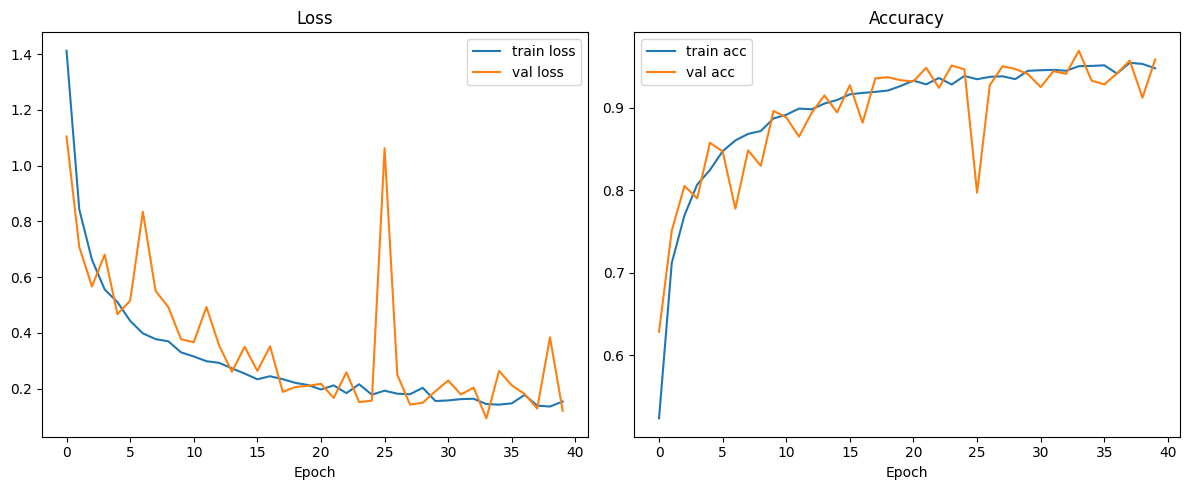

Best val_accuracy: 0.9693 at epoch 34


In [26]:
#    train model  
import math
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

EPOCHS = 50
BATCH_SIZE = 32  
STEPS_PER_EPOCH = math.ceil(train_gen.samples / BATCH_SIZE)
VALIDATION_STEPS = math.ceil(val_gen.samples / BATCH_SIZE)

# Compile
model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

# Callbacks
es = EarlyStopping(monitor="val_loss", patience=6, restore_best_weights=True, verbose=1)
ckpt = ModelCheckpoint("best_model.h5", monitor="val_loss", save_best_only=True, verbose=1)

# Train
history = model.fit(
    train_gen,
    steps_per_epoch=STEPS_PER_EPOCH,
    epochs=EPOCHS,
    validation_data=val_gen,
    validation_steps=VALIDATION_STEPS,
    callbacks=[es, ckpt],
    verbose=1
)

# Plot train / val loss and accuracy
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title("Loss")
plt.xlabel("Epoch")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.legend()

plt.tight_layout()
plt.show()

# Print best epoch info
val_accs = history.history.get('val_accuracy', [])
if val_accs:
    best_epoch = int(np.argmax(val_accs)) + 1
    print(f"Best val_accuracy: {max(val_accs):.4f} at epoch {best_epoch}")
else:
    print("No validation accuracy recorded.")


69/69 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step
Classification Report:

                                               precision    recall  f1-score   support

                      Tomato___Bacterial_spot     0.9723    0.9609    0.9666       256
                        Tomato___Early_blight     0.9550    0.8833    0.9177       120
                         Tomato___Late_blight     0.9683    0.9345    0.9511       229
                           Tomato___Leaf_Mold     0.9655    0.9825    0.9739       114
                  Tomato___Septoria_leaf_spot     0.9204    0.9765    0.9476       213
Tomato___Spider_mites Two-spotted_spider_mite     0.9655    0.9751    0.9703       201
                         Tomato___Target_Spot     0.9209    0.9702    0.9449       168
       Tomato___Tomato_Yellow_Leaf_Curl_Virus     1.0000    0.9907    0.9953       643
                 Tomato___Tomato_mosaic_virus     0.9783    1.0000    0.9890        45
                             Tomato___healthy     0.9947    0.989

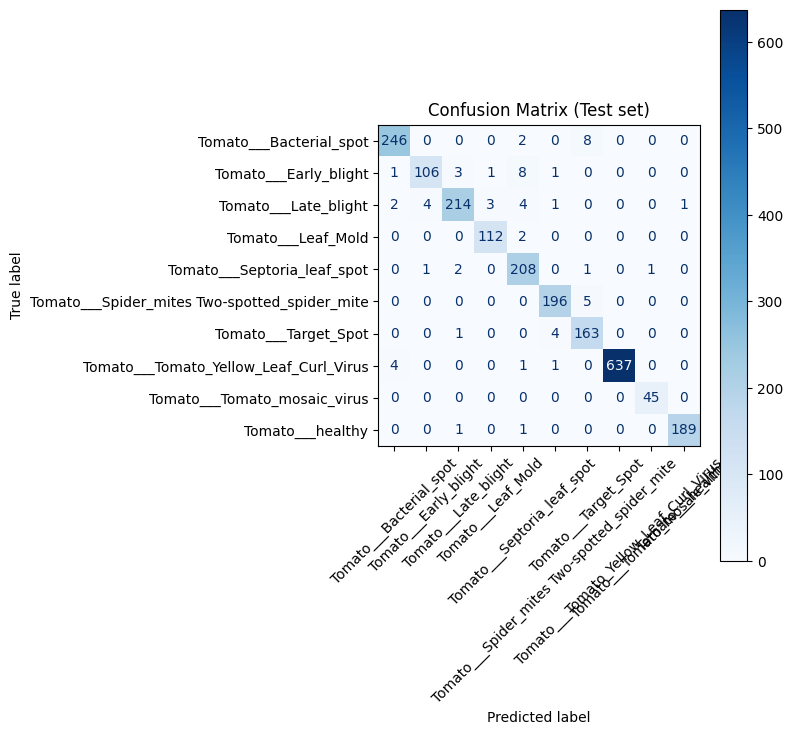

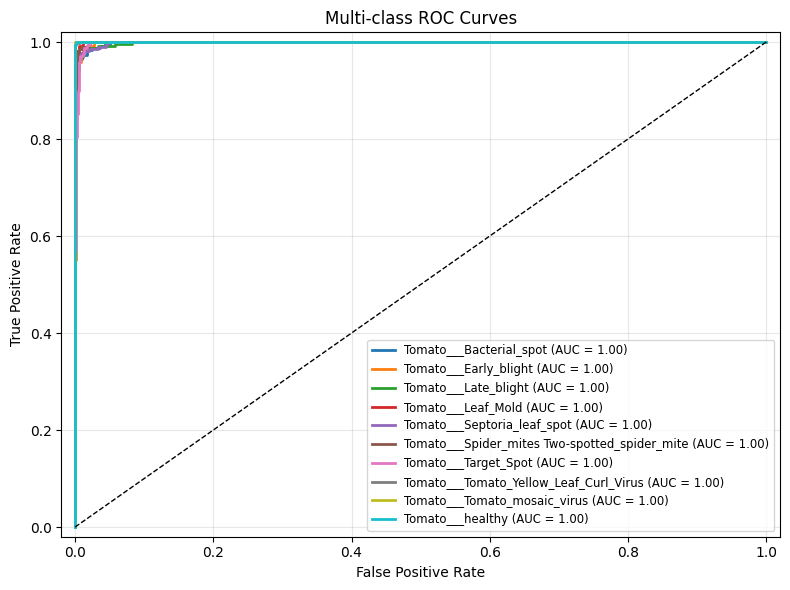


Total misclassified on test set: 64


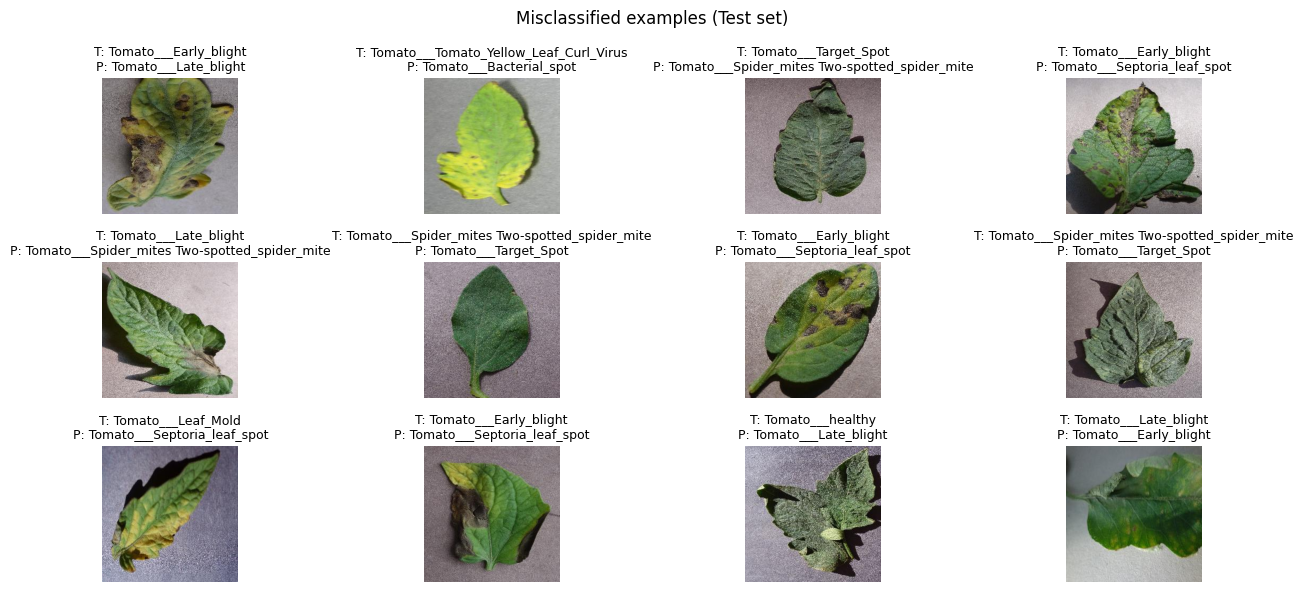


One sample per class — prediction check:


/tmp/ipykernel_47/2386810086.py:106: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  ids = np.where(y_true_idx == cls_idx)[0]


<Figure size 1400x400 with 0 Axes>

In [ ]:
#  Evaluate
import math
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, f1_score
from sklearn.preprocessing import label_binarize
import itertools
from tensorflow.keras.models import load_model

#  
TEST_STEPS = math.ceil(test_gen.samples / test_gen.batch_size)
test_gen.reset()                                      
y_proba = model.predict(test_gen, steps=TEST_STEPS, verbose=1)    
y_pred_idx = np.argmax(y_proba, axis=1)


y_true_idx = test_gen.classes[: len(y_pred_idx)]

# mapping 
idx_to_class = {v: k for k, v in train_gen.class_indices.items()}
class_names = [idx_to_class[i] for i in sorted(idx_to_class)]

# Classification report 
print("Classification Report:\n")
print(classification_report(y_true_idx, y_pred_idx, target_names=class_names, digits=4))

macro_f1 = f1_score(y_true_idx, y_pred_idx, average="macro")
weighted_f1 = f1_score(y_true_idx, y_pred_idx, average="weighted")
print(f"Macro F1:    {macro_f1:.4f}")
print(f"Weighted F1: {weighted_f1:.4f}")

#   Confusion Matrix  
cm = confusion_matrix(y_true_idx, y_pred_idx)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

fig, ax = plt.subplots(figsize=(8, 8))
disp.plot(ax=ax, cmap="Blues", xticks_rotation=45, colorbar=True)
plt.title("Confusion Matrix (Test set)")
plt.tight_layout()
plt.show()

#  ROC curves  ---
 
n_classes = len(class_names)
y_true_bin = label_binarize(y_true_idx, classes=list(range(n_classes)))

 
if y_proba.shape[0] != y_true_bin.shape[0]:
    y_proba = y_proba[: y_true_bin.shape[0]]

from sklearn.metrics import roc_curve, auc

plt.figure(figsize=(8, 6))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_proba[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f"{class_names[i]} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], "k--", lw=1)
plt.xlim([-0.02, 1.02])
plt.ylim([-0.02, 1.02])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Multi-class ROC Curves")
plt.legend(loc="lower right", fontsize="small")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

 
mis_idx = np.where(y_pred_idx != y_true_idx)[0]
print(f"\nTotal misclassified on test set: {len(mis_idx)}")

n_show = min(12, len(mis_idx))
if n_show > 0:
    plt.figure(figsize=(14, 6))
    for i, m in enumerate(mis_idx[:n_show]):
       
        try:
            img_path = test_gen.filepaths[m]  
        except Exception:
 
            img_path = test_df.iloc[m].filepath

        img = plt.imread(img_path)
        plt.subplot(3, 4, i + 1)
        plt.imshow(img)
        plt.axis("off")
        true_label = idx_to_class[y_true_idx[m]]
        pred_label = idx_to_class[y_pred_idx[m]]
        plt.title(f"T: {true_label}\nP: {pred_label}", fontsize=9)
    plt.suptitle("Misclassified examples (Test set)")
    plt.tight_layout()
    plt.show()
else:
    print("No misclassified examples to display.")

 
print("\nOne sample per class — prediction check:")
plt.figure(figsize=(14, int(2 * np.ceil(n_classes / 7))))
per_class_shown = 0
cols = 7
for cls_idx in range(n_classes):
   
    ids = np.where(y_true_idx == cls_idx)[0]
    if len(ids) == 0:
        continue
    m = ids[0]
    try:
        img_path = test_gen.filepaths[m]
    except Exception:
        img_path = test_df.iloc[m].filepath

    img = plt.imread(img_path)
    pred_lbl = idx_to_class[y_pred_idx[m]]
    true_lbl = idx_to_class[cls_idx]

    per_class_shown += 1
    ax = plt.subplot(int(np.ceil(n_classes / cols)), cols, per_class_shown)
    plt.imshow(img)
    plt.axis("off")
    title_col = "green" if pred_lbl == true_lbl else "red"
    ax.set_title(f"T:{true_lbl}\nP:{pred_lbl}", fontsize=9, color=title_col)

plt.suptitle("One sample per class (from test set) — green if correct, red if wrong")
plt.tight_layout()
plt.show()


Using existing: best_model.h5
Using existing: best_model.keras
SavedModel directory exists: saved_model_export

Reloaded model summary:


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │    12,845,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,939,724 (49.36 MB)

 Trainable params: 12,939,722 (49.36 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

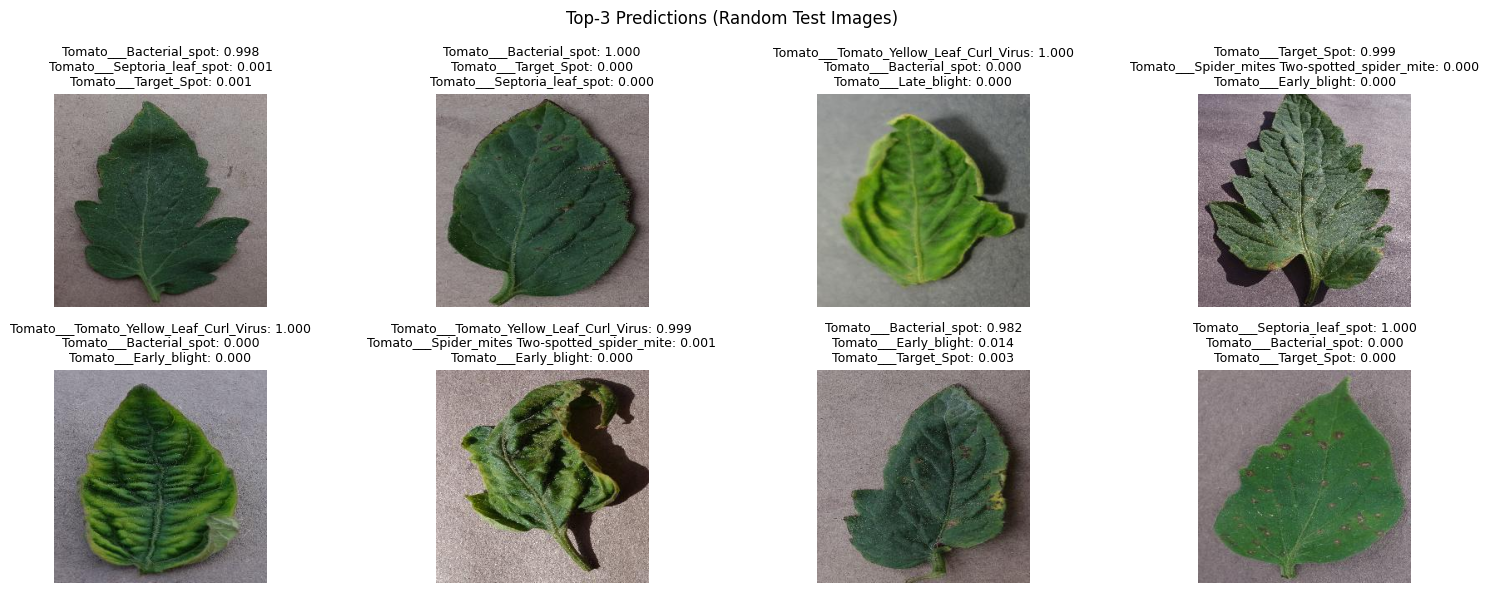


Text Prediction Output:
8571dec5-c1d3-4d91-8b7e-2d1c188bede6___GCREC_Bact.Sp 5683.JPG => [('Tomato___Bacterial_spot', 0.998320996761322), ('Tomato___Septoria_leaf_spot', 0.0007783615728840232), ('Tomato___Target_Spot', 0.0006597752217203379)]
f14c5648-4fde-4e6c-8937-6fb2e33aa95f___GCREC_Bact.Sp 5666.JPG => [('Tomato___Bacterial_spot', 0.9999997615814209), ('Tomato___Target_Spot', 2.8046122224623105e-07), ('Tomato___Septoria_leaf_spot', 1.6896676058308913e-08)]
cc007d31-b838-4ce8-b5ac-572bbe788084___UF.GRC_YLCV_Lab 02324.JPG => [('Tomato___Tomato_Yellow_Leaf_Curl_Virus', 0.9999741315841675), ('Tomato___Bacterial_spot', 2.5822351744864136e-05), ('Tomato___Late_blight', 5.129339175624636e-10)]
f2e0f0c8-503c-4889-b39a-c5b2acbce17e___Com.G_TgS_FL 0929.JPG => [('Tomato___Target_Spot', 0.9994749426841736), ('Tomato___Spider_mites Two-spotted_spider_mite', 0.0004956514458172023), ('Tomato___Early_blight', 2.933807991212234e-05)]
9ca23fe4-e698-4cd4-ae7e-63c7777cfa65___YLCV_GCREC 2762.JPG => [(

In [31]:
#   Save model,  
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import random, os
import matplotlib.pyplot as plt

 

#   Save HDF5
MODEL_H5 = "best_model.h5"
if not os.path.exists(MODEL_H5):
    model.save(MODEL_H5)
    print("Saved:", MODEL_H5)
else:
    print("Using existing:", MODEL_H5)

#   Save in native Keras format
MODEL_KERAS = "best_model.keras"
if not os.path.exists(MODEL_KERAS):
    model.save(MODEL_KERAS)
    print("Saved:", MODEL_KERAS)
else:
    print("Using existing:", MODEL_KERAS)

#  Export SavedModel  
SAVED_MODEL_DIR = "saved_model_export"
if not os.path.exists(SAVED_MODEL_DIR):
    model.export(SAVED_MODEL_DIR)
    print("Exported SavedModel:", SAVED_MODEL_DIR)
else:
    print("SavedModel directory exists:", SAVED_MODEL_DIR)

# Reload model to confirm it loads correctly
loaded_model = load_model(MODEL_H5)
print("\nReloaded model summary:")
loaded_model.summary()

 
IMG_TARGET = (224, 224)

def predict_topk(image_path, model, class_map, topk=3):
    img = load_img(image_path, target_size=IMG_TARGET)
    x = img_to_array(img) / 255.0
    x = np.expand_dims(x, axis=0)
    preds = model.predict(x, verbose=0)[0]

    idx_sorted = np.argsort(preds)[::-1][:topk]
    inv_map = {v: k for k, v in class_map.items()}
    return [(inv_map[i], float(preds[i])) for i in idx_sorted]

 
n_examples = 8
random.seed(42)
test_indices = random.sample(range(len(test_df)), min(n_examples, len(test_df)))

plt.figure(figsize=(16, 6))
for i, idx in enumerate(test_indices, 1):
    img_path = test_df.iloc[idx].filepath
    preds = predict_topk(img_path, loaded_model, train_gen.class_indices, topk=3)

    img = plt.imread(img_path)
    ax = plt.subplot(2, 4, i)
    plt.imshow(img)
    plt.axis("off")

    title = "\n".join([f"{p[0]}: {p[1]:.3f}" for p in preds])
    ax.set_title(title, fontsize=9)

plt.suptitle("Top-3 Predictions (Random Test Images)")
plt.tight_layout()
plt.show()

#  Text output  
print("\nText Prediction Output:")
for idx in test_indices:
    img_path = test_df.iloc[idx].filepath
    preds = predict_topk(img_path, loaded_model, train_gen.class_indices, topk=3)
    print(os.path.basename(img_path), "=>", preds)
